# Compressive Sampling the TM of an MMF

This notebook contains my most recent work on my MPhys Project, the project itself is ongoing and not due to finish until March 2026, so no code is complete in this notebook and errors do occur currently. I expect to continue work on this after Christmas.

The best view of my coding work on this project can be seen in the 'Functions' folder.

In [1]:
import sys
original_sys_path = sys.path.copy()
import random
import scipy as sc
from scipy import sparse

sys.path.append("/kaggle/input/fibre-functions")
from fibrefunctions import *
from fibremodels import *
from fibredata import *
# Reset system path
sys.path = original_sys_path

Files (42) imported from USB.
Files (189) imported from USB.


f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:188: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


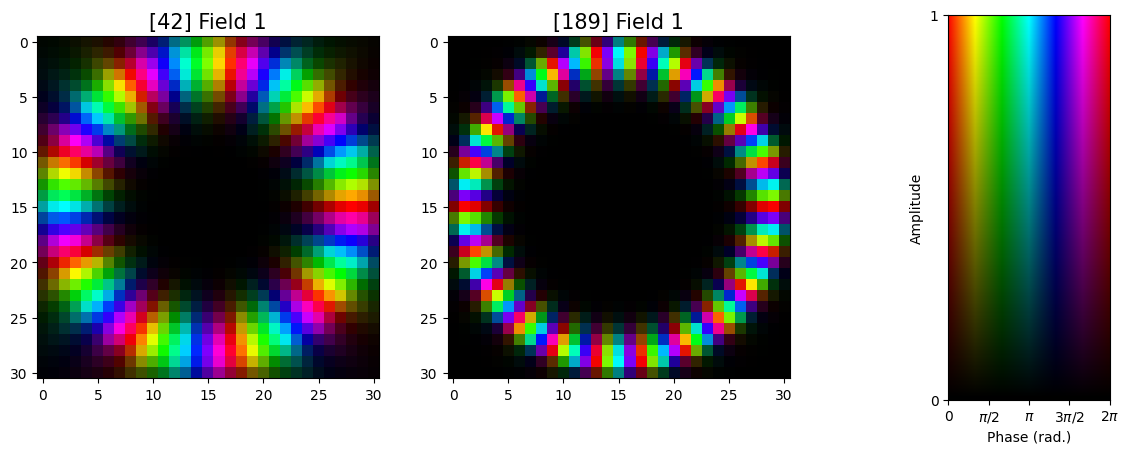

In [2]:
# Check imports and data is working correctly by plotting one of the fields
visualise2(PIMs_torch[0], PIMs_torch189[0], "", "[42] Field 1", "[189] Field 1")

## PIM Power Spectrum
Made a function "PP_Spectrum" that plots the PIM Power Spectrum triangle for easy viewing.

f:\venv code\.venv\lib\site-packages\matplotlib\colors.py:3174: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


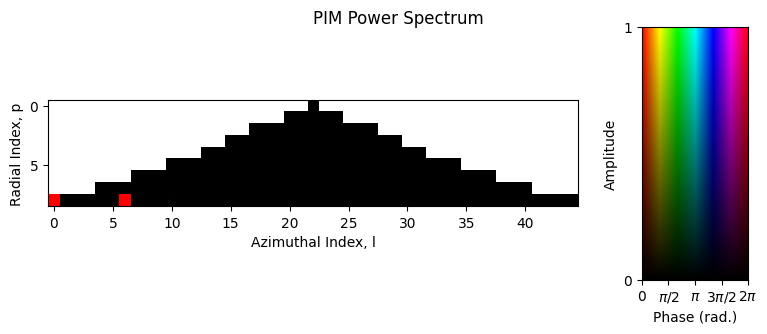

In [4]:
PP_spectrum(PIMs_torch189[9]+PIMs_torch189[0], uwlm189, PIMs_torch189)

In [5]:
# Ordered list of PIMs from uwlm
u,w,l,p = np.hsplit(uwlm,4)
lp_list = []
for i in range(l.size):
    lp_list.append([l[i][0],p[i][0]])
lp_list[0][0]

-9.0

In [6]:
def sampled_TM(sig_l, sig_p, uwlp=uwlm):
    """Generates a PIM basis transmission matrix that only contains an amplitude component. 
    Generated from given uwlp values and sig_l and sig_p."""
    # Ordered list of PIMs from uwlm
    u,w,l,p = np.hsplit(uwlm,4)
    lp_list = []
    for i in range(l.size):
        lp_list.append([l[i][0],p[i][0]])

    # Make fully sampled PIM basis TM
    compressive_TM = []
    for i in range(len(lp_list)):
        l0 = torch.tensor(lp_list[i][0])
        p0 = torch.tensor(lp_list[i][1])
        gauss_n = []
        for j in range(len(lp_list)):
            l = torch.tensor(lp_list[j][0])
            p = torch.tensor(lp_list[j][1])
            gauss_n.append(coupling_gaussian(l, p, l0, p0, sig_l, sig_p))
        compressive_TM.append(gauss_n)

    compressive_TM = np.array(compressive_TM)
    return torch.from_numpy(compressive_TM)

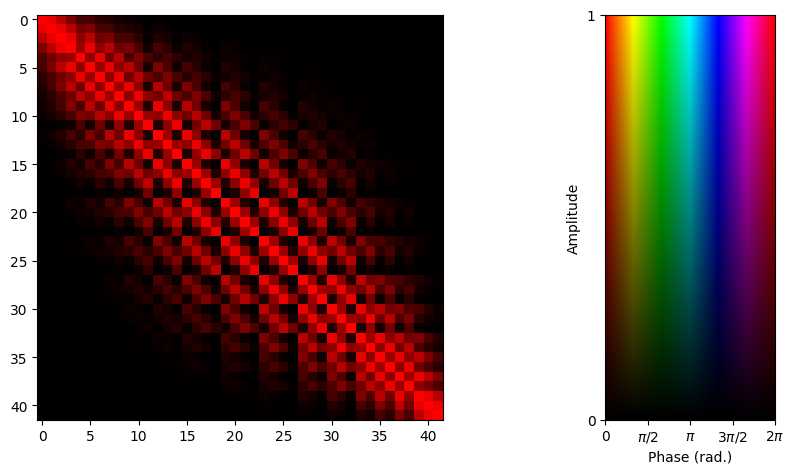

In [7]:
visualise(sampled_TM(2.5,1))

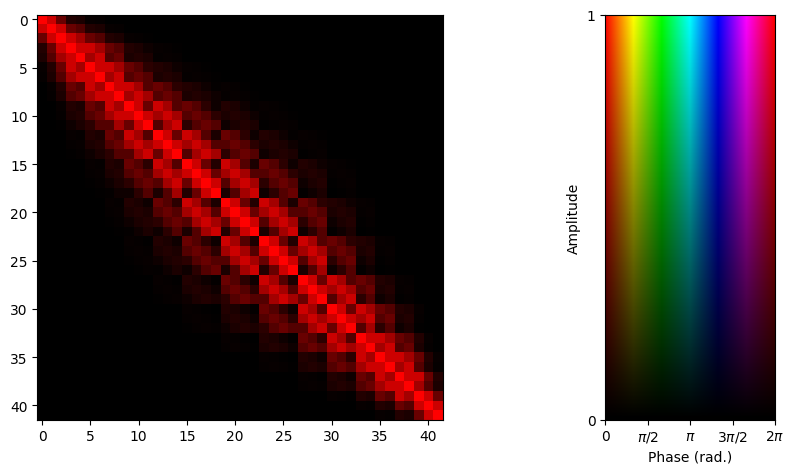

In [8]:
compressive_TM = []
for i in range(len(lp_list)):
    l0 = torch.tensor(lp_list[i][0])
    p0 = torch.tensor(lp_list[i][1])
    gauss_n = []
    for j in range(len(lp_list)):
        l = torch.tensor(lp_list[j][0])
        p = torch.tensor(lp_list[j][1])
        gauss_n.append(coupling_gaussian(l, p, l0, p0, 1.5, 1.5))
    compressive_TM.append(gauss_n)

compressive_TM = np.array(compressive_TM)
compressive_TM = torch.from_numpy(compressive_TM)

visualise(compressive_TM)

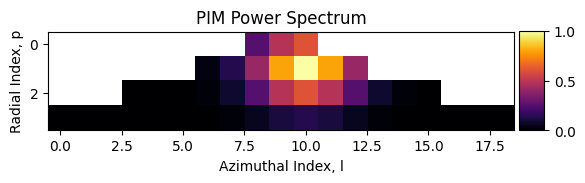

In [9]:
PP_spectrum_gauss(1, 2, 1.5, 1, uwlm)

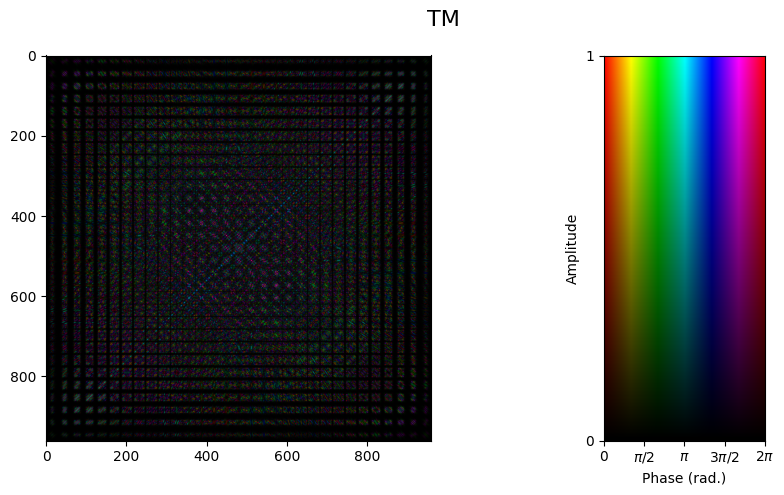

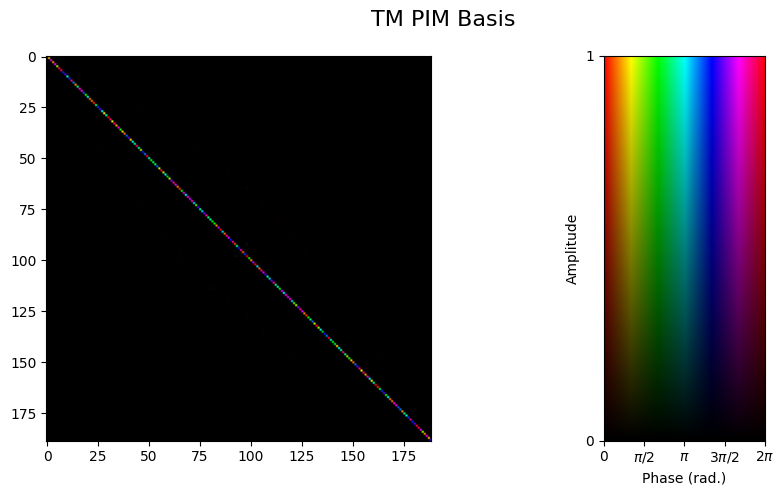

In [10]:
pim_mat = pim_matrix(PIMs_torch189)
real_mat = real_matrix(PIMs_torch189)
b_mat = beta_matrix(beta_torch189, 0.1)
bend_vec_x = vectorise(zernike_array('x',torch.tensor([0.5])))
bend_vec_y = vectorise(zernike_array('y', torch.tensor([0.3])))
bend_diag_x = torch.diag(bend_vec_x.T[0])
bend_diag_y = torch.diag(bend_vec_y.T[0])

#test_mat = (real_mat @ (b_mat @ pim_mat)) @ ((bend_diag_y @ bend_diag_x) @ (real_mat @ (b_mat @ pim_mat)))
test_mat = (real_mat @ (b_mat @ pim_mat)) @ (real_mat @ (b_mat @ pim_mat))
visualise(test_mat, "TM")

# TM in PIM basis
test_pim_mat = pim_mat @ test_mat @ real_mat
visualise(test_pim_mat, "TM PIM Basis")

[7, 17, 22]


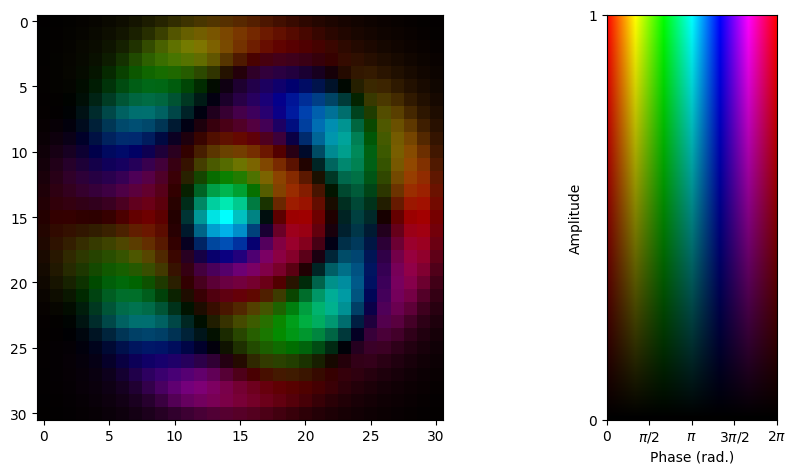

In [11]:
field, used_pims = pim_superposition(3, rand=True)
visualise(field)
print(used_pims)

[29]


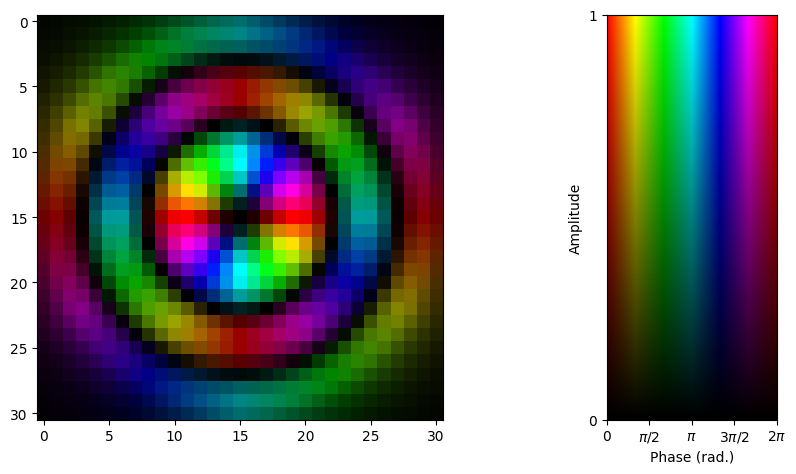

In [12]:
field, used_pims = pim_superposition(1, rand=True)
visualise(field)
print(used_pims)

f:\venv code\.venv\lib\site-packages\matplotlib\colors.py:3174: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


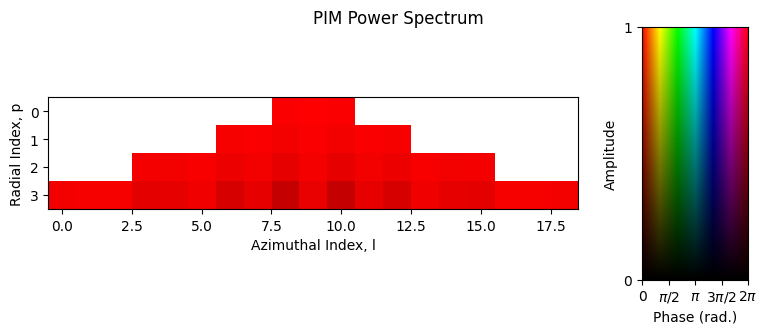

In [13]:
field, used_pims = pim_superposition(42)

PP_spectrum(field, uwlm, PIMs_torch, show_phase=True)
#PP_spectrum(field, uwlm, PIMs_torch, show_phase=False)

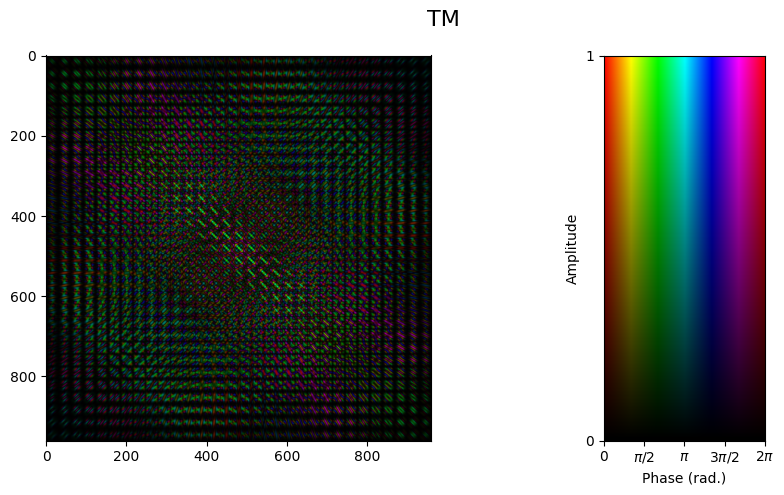

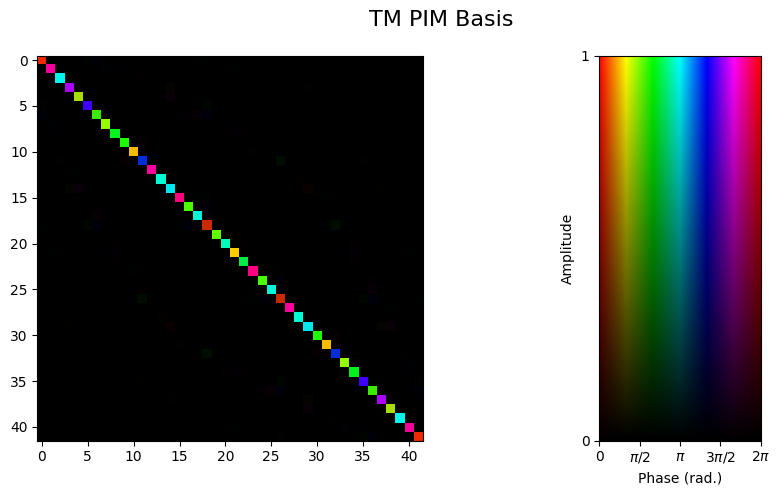

In [14]:
pim_mat = pim_matrix(PIMs_torch)
real_mat = real_matrix(PIMs_torch)
b_mat = beta_matrix(beta_torch, 0.01)
bend_vec_x = vectorise(zernike_array('x',torch.tensor([0.5])))
bend_vec_y = vectorise(zernike_array('y', torch.tensor([0.3])))
bend_diag_x = torch.diag(bend_vec_x.T[0])
bend_diag_y = torch.diag(bend_vec_y.T[0])

#test_mat = (real_mat @ (b_mat @ pim_mat)) @ ((bend_diag_y @ bend_diag_x) @ (real_mat @ (b_mat @ pim_mat)))
test_mat = (real_mat @ (b_mat @ pim_mat)) @ (real_mat @ (b_mat @ pim_mat))
visualise(test_mat, "TM")

# TM in PIM basis
test_pim_mat = pim_mat @ test_mat @ real_mat
visualise(test_pim_mat, "TM PIM Basis")

## Make a fibre model and use all PIMs to find the PIM basis TM for it

In [23]:
class Fibre:
    def __init__(self, modes, betas, segment_len:float, bends:list):
        self.segment_len = segment_len
        self.bends = bends
        self.modes = modes
        self.betas = betas

    def TM(self, PIM_basis=False):
        """Generates the transmission matrix for the fibre using all available PIMs.
          Can return the TM in the real or PIM basis, defaulting to the real basis."""
        
        # Compute TM in real basis
        pim_mat = pim_matrix(self.modes)
        real_mat = real_matrix(self.modes)
        beta_mat = beta_matrix(self.betas, self.segment_len)
        segment_prop = real_mat @ (beta_mat @ pim_mat)

        # Compute the first straight segment propagation
        tm = segment_prop
        # Loop over all bends and apply the change due to bend + propagation
        if len(self.bends) > 0:
            for i in range(len(self.bends)):
                bend_vec_x = vectorise(zernike_array('x',torch.tensor([self.bends[i][0]])))
                bend_vec_y = vectorise(zernike_array('y', torch.tensor([self.bends[i][1]])))
                bend_diag_x = torch.diag(bend_vec_x.T[0])
                bend_diag_y = torch.diag(bend_vec_y.T[0])
                tm = segment_prop @ ((bend_diag_y @ bend_diag_x) @ tm)
                #print(f"Pass: {i+1}")
        else:
            #print("No bend")
            pass
        
        # Return TM in specified format
        if PIM_basis == True:
            tm = pim_mat @ tm @ real_mat
        else: 
            pass
        
        return tm
    
    def forward(self, input_field):
        """Propagates a field through the fibre and returns the new field.
        A forward pass of the model."""
        tm = self.TM()
        return unvectorise(tm @ vectorise(input_field), self.modes[0].shape[0])


In [28]:
PIMs_torch[0].shape[0]

31

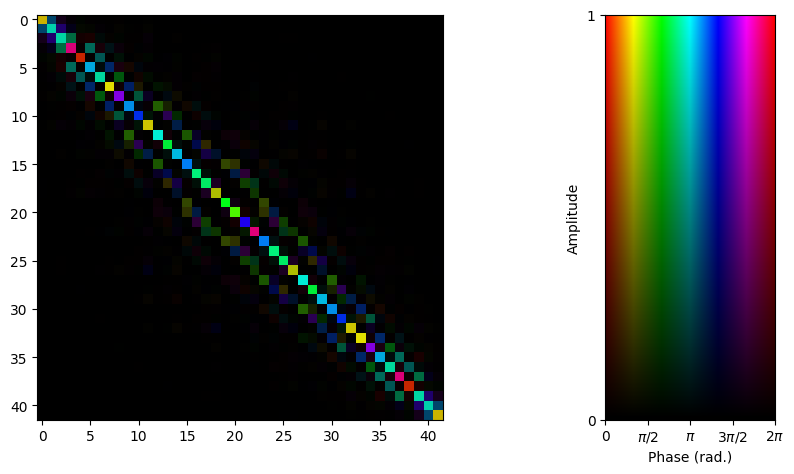

In [20]:
no_bend = []
one_bend = [[0.5,0]]
bends = [[1,0],[1,0],[1,0]]
#fib = Fibre(PIMs_torch, beta_torch, 10, no_bend)
fib = Fibre(PIMs_torch, beta_torch, 0.05, one_bend)

visualise(fib.TM(True))

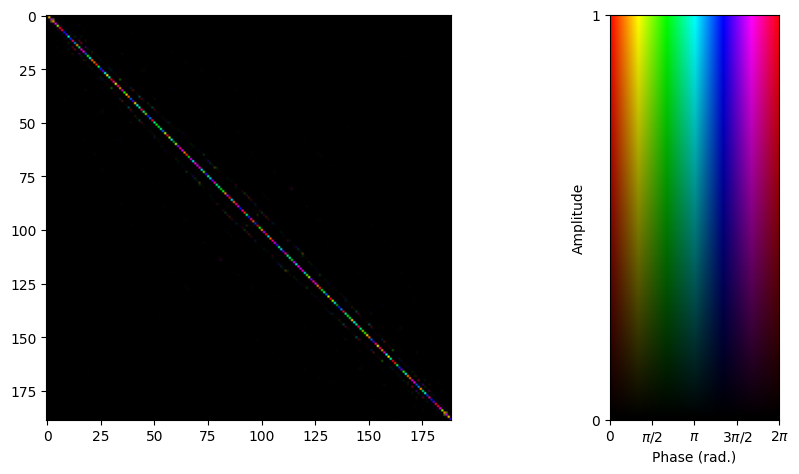

In [21]:
no_bend = []
one_bend = [[0.5,0]]
#bends = [[0.5/3,0],[0.5/3,0],[0.5/3,0]]
bends = [[0.5/7,0],[0.5/7,0],[0.5/7,0],[0.5/7,0],[0.5/7,0],[0.5/7,0],[0.5/7,0]]
#fib = Fibre(PIMs_torch189, beta_torch189, 0.05, one_bend)
fib = Fibre(PIMs_torch189, beta_torch189, 0.1/4, bends)

visualise(fib.TM(True))

## Columnwise reconstruction

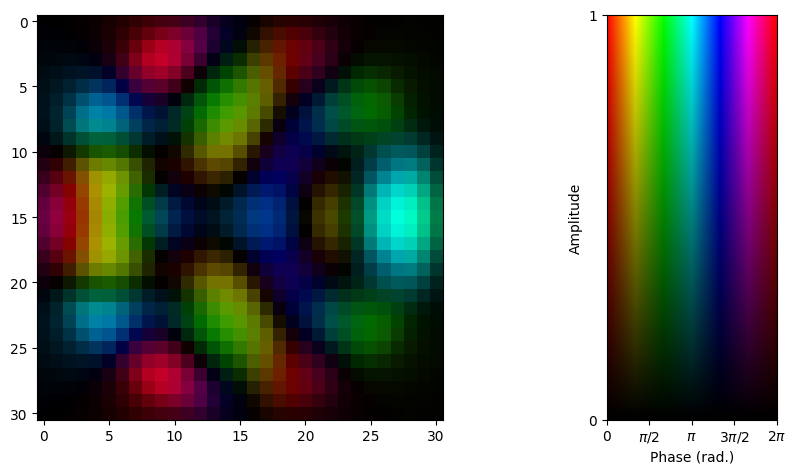

In [ ]:
# For a perfectly straight fibre, the reconstruction only requires 1 field: A known superposition of all the PIMs.
bends = [[0,0],[0,0],[0,0]]
fibre = Fibre(PIMs_torch, beta_torch, 0.025, bends)

#visualise(fibre.TM(True), "TM from matrix multiplication")

# Make a field from a superposition of all PIMs
field, used_pims = pim_superposition(42, rand=False)
#visualise(field, "Superposition of all PIMs")

# Propagate the field through the fibre
field_out = fibre.forward(field)
#visualise(field_out)

#

In [3]:
vectorise(torch.tensor([[1,2,3],[4,5,6],[7,8,9]]))


tensor([[1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

## Sparse Loss Function

In [3]:
# Try an inital t estimate of a perfectly diagonal TM (for now assume we know the length L of the fibre)
init_t = beta_matrix(beta_torch, 0.1)

In [4]:
def dagger(mat):
    """Computes the complex conjugate transpose of a matrix."""
    return torch.transpose(torch.conj(mat), dim0=0, dim1=1)

In [59]:
def sparse_TM(target, S, w, t, lamb=1):
    """A function that generates a sparse TM taking into account that most the power of the TM is on the main diagonal,
    leaving it mostly sparse in the PIM basis."""

    # Vectorise the estimated support TM
    w_vec = vectorise(w)

    # Initialise parameters for the while loop
    muk = 1
    xk = t
    tk = t
    a = 0.1 # Temp value
    iteration = 0

    tk_step = torch.zeros_like(t)

    while torch.linalg.norm(vectorise((tk-tk_step)).T, dim=1, ord = 2) < 1e-6:
        zi = tk - a*(dagger(S)*(S*tk - target))

        xk_step = max(0, 1 - (a*lamb*w_vec)/ torch.linalg.norm(zi)) * zi

        muk_step = 0.5 * (1 + (4*muk**2 + 1)**0.5)

        tk_step = xk_step + ((muk - 1)/muk_step)*(xk_step - xk)

        iteration += 1
        print(iteration)
        xk = xk_step
        muk = muk_step
        tk = tk_step

        if iteration > 1e6:
            print(f"Iteration exceeded {iteration}. While loop broken.")
            break
    
    print(torch.linalg.norm(vectorise((tk-tk_step)).T, dim=1, ord = 2))
    return tk

In [38]:
def find_sensing_matrix(inputs:list, outputs:list):
    """Computes the sensing matrix S and  vector y from a list of input and output vectors"""
    # Size
    N = inputs[0].shape[0]
    # Find y
    y = vectorise(torch.cat(outputs, 1).T)

    # Find S
    I = torch.eye(N)
    A = torch.cat(inputs, 1).T.reshape(N, len(inputs))
    print(I.shape)
    print(A.shape)
    S = torch.kron(I,A)

    return S, y

In [29]:
n = 21
inputs = []
for i in range(n):
    temp = torch.zeros((42,1), dtype=torch.cdouble)
    temp[i] = 1
    inputs.append(temp)

bends = [[1,0],[1,0],[1,0]]
fib = Fibre(PIMs_torch, beta_torch, 0.05, bends)

outputs = []
for i in range(n):
    outputs.append(fib.TM(True) @ inputs[i])

In [39]:
S, y = find_sensing_matrix(inputs, outputs)

torch.Size([42, 42])
torch.Size([42, 21])


tensor([6.4807], dtype=torch.float64)


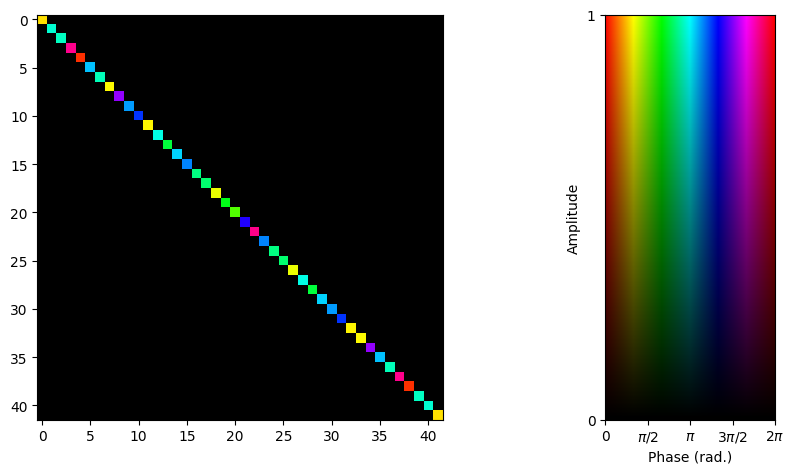

In [60]:
visualise(sparse_TM(y, S, sampled_TM(2.5,1), init_t))

In [52]:
torch.linalg.norm(vectorise(torch.tensor([[1,1,1],[2,2,2],[3,3,3]], dtype=torch.cfloat)).T, dim=1, ord = 2)

tensor([6.4807])

In [61]:
input("Hello!")

''

In [62]:
zi = init_t - 0.1*(dagger(S)*(S*init_t - y))

RuntimeError: The size of tensor a (882) must match the size of tensor b (42) at non-singleton dimension 1